In [7]:
AUDIO_DIR = "/Users/zainhazzouri/projects/Bachelor_Thesis/Data/Kaggle"
SAMPLE_RATE = 22050 # sample rate of the audio file
bit_depth = 16 # bit depth of the audio file
hop_length = 512
n_mfcc = 20 # number of MFCCs features
n_fft=1024, # window size
n_mels = 256 # number of mel bands to generate
win_length = None # window length


# Training parameters
batch_size = 16
learning_rate = 0.001
num_epochs = 20




In [8]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio
import glob
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

import nbimporter
from cnn_model import CNNModel

class SpeechMusicDataset(Dataset):
    def __init__(self, music_waves, speech_waves, transform=None):
        self.music_waves = music_waves
        self.speech_waves = speech_waves
        self.transform = transform
        self.file_list = self.music_waves + self.speech_waves

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_path = self.file_list[idx]
        waveform, _ = torchaudio.load(file_path)
        label = 0 if 'music_wav' in file_path else 1

        if self.transform:
            waveform = self.transform(waveform)

        return waveform, label

# Preprocessing function for the dataset
def preprocess(waveform, target_length=8000, sample_rate=SAMPLE_RATE, n_mfcc=n_mfcc):
    waveform_length = waveform.size(1)

    if waveform_length < target_length:
        num_padding = target_length - waveform_length
        padding = torch.zeros(1, num_padding)
        waveform = torch.cat((waveform, padding), 1)
    elif waveform_length > target_length:
        waveform = waveform[:, :target_length]

    mfcc = torchaudio.transforms.MFCC(sample_rate=sample_rate, n_mfcc=n_mfcc)(waveform)
    return mfcc

# Set device
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_built():  # if you have apple silicon mac
    device = "mps"  # if it doesn't work try device = torch.device('mps')
else:
    device = "cpu"
print(f"Using {device}")

# Set the path to the folder containing the music and speech datasets
AUDIO_DIR = "/Users/zainhazzouri/projects/Bachelor_Thesis/Data/Kaggle/"

# Load the dataset
music_waves = glob.glob(AUDIO_DIR + "music_wav" + "/*.wav")
speech_waves = glob.glob(AUDIO_DIR + "speech_wav" + "/*.wav")
transform = preprocess

dataset = SpeechMusicDataset(music_waves, speech_waves, transform=transform)






def pad_waveform(waveform, desired_length):
    if waveform.shape[-1] < desired_length:
        padding = desired_length - waveform.shape[-1]
        waveform = torch.nn.functional.pad(waveform, (0, padding))
    return waveform






# Load the dataset
music_waves = glob.glob(AUDIO_DIR + "music_wav" + "/*.wav")
speech_waves = glob.glob(AUDIO_DIR + "speech_wav" + "/*.wav")
transform = preprocess

dataset = SpeechMusicDataset(music_waves, speech_waves, transform=transform)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])








# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Initialize model, loss, and optimizer
model = CNNModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


Using mps


In [9]:
# Evaluation function

#1. Average validation loss: This metric is calculated using the same loss function (`criterion`) used during training, which is CrossEntropyLoss in this case. The average validation loss is computed by summing the losses for all validation samples and then dividing by the number of validation samples. A lower average validation loss indicates better performance.
#
# 2. Validation accuracy: This metric measures the percentage of correctly classified samples in the validation set. The accuracy is calculated by counting the number of correct predictions, i.e., when the predicted label matches the true label, and then dividing by the total number of validation samples. A higher validation accuracy indicates better performance.
#
# These two metrics together provide a good evaluation of the model's performance on the validation set. The average validation loss helps assess the model's ability to minimize the loss function, while the validation accuracy measures how well the model is classifying the samples.


def evaluate(val_loader, model, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Forward pass
            outputs = model(inputs)

            # Calculate loss
            loss = criterion(outputs, targets)

            # Update loss
            running_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    # Calculate average loss and accuracy
    avg_loss = running_loss / len(val_loader)
    accuracy = 100 * correct / total

    return avg_loss, accuracy

# Evaluate the model
val_loss, val_accuracy = evaluate(val_loader, model, criterion, device)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.2f}%")

Validation Loss: 1.3531
Validation Accuracy: 53.85%


In [10]:
# Initialize lists for storing loss and accuracy
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []




# Training loop
# Training loop
for epoch in range(num_epochs):
    print(f"Epoch: {epoch+1}/{num_epochs}")

    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (inputs, targets) in enumerate(tqdm(train_loader, desc="Training", ncols=100)):
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Calculate loss
        loss = criterion(outputs, targets)

        # Backward pass
        loss.backward()

        # Optimize
        optimizer.step()

        # Update loss
        running_loss += loss.item()

        # Update total and correct
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

    # Calculate average loss and accuracy for the epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    # Validate and store the validation loss and accuracy
    val_loss, val_accuracy = evaluate(val_loader, model, criterion, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Train Loss: {epoch_loss:.4f} | Train Accuracy: {epoch_accuracy:.2f}%")
    print(f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_accuracy:.2f}%")

print("Training finished.")



Epoch: 1/20


Training: 100%|███████████████████████████████████████████████████████| 7/7 [00:00<00:00, 13.96it/s]


Train Loss: 1.1375 | Train Accuracy: 52.94%
Validation Loss: 0.9701 | Validation Accuracy: 46.15%
Epoch: 2/20


Training: 100%|███████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.80it/s]


Train Loss: 0.8701 | Train Accuracy: 50.98%
Validation Loss: 0.8917 | Validation Accuracy: 46.15%
Epoch: 3/20


Training: 100%|███████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.76it/s]


Train Loss: 0.7706 | Train Accuracy: 50.98%
Validation Loss: 0.7799 | Validation Accuracy: 46.15%
Epoch: 4/20


Training: 100%|███████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.84it/s]


Train Loss: 0.6766 | Train Accuracy: 51.96%
Validation Loss: 0.6977 | Validation Accuracy: 46.15%
Epoch: 5/20


Training: 100%|███████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.92it/s]


Train Loss: 0.6335 | Train Accuracy: 52.94%
Validation Loss: 0.6600 | Validation Accuracy: 57.69%
Epoch: 6/20


Training: 100%|███████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.74it/s]


Train Loss: 0.5961 | Train Accuracy: 66.67%
Validation Loss: 0.6552 | Validation Accuracy: 57.69%
Epoch: 7/20


Training: 100%|███████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.16it/s]


Train Loss: 0.5547 | Train Accuracy: 69.61%
Validation Loss: 0.6675 | Validation Accuracy: 46.15%
Epoch: 8/20


Training: 100%|███████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.81it/s]


Train Loss: 0.6053 | Train Accuracy: 69.61%
Validation Loss: 0.6618 | Validation Accuracy: 53.85%
Epoch: 9/20


Training: 100%|███████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.01it/s]


Train Loss: 0.6755 | Train Accuracy: 68.63%
Validation Loss: 0.6714 | Validation Accuracy: 69.23%
Epoch: 10/20


Training: 100%|███████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.10it/s]


Train Loss: 0.6661 | Train Accuracy: 76.47%
Validation Loss: 0.6736 | Validation Accuracy: 46.15%
Epoch: 11/20


Training: 100%|███████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.09it/s]


Train Loss: 0.6039 | Train Accuracy: 53.92%
Validation Loss: 0.6199 | Validation Accuracy: 73.08%
Epoch: 12/20


Training: 100%|███████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.80it/s]


Train Loss: 0.5077 | Train Accuracy: 84.31%
Validation Loss: 0.6761 | Validation Accuracy: 80.77%
Epoch: 13/20


Training: 100%|███████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.51it/s]


Train Loss: 0.4971 | Train Accuracy: 83.33%
Validation Loss: 0.6456 | Validation Accuracy: 76.92%
Epoch: 14/20


Training: 100%|███████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.14it/s]


Train Loss: 0.5159 | Train Accuracy: 82.35%
Validation Loss: 0.6013 | Validation Accuracy: 69.23%
Epoch: 15/20


Training: 100%|███████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.01it/s]


Train Loss: 0.4044 | Train Accuracy: 82.35%
Validation Loss: 0.5615 | Validation Accuracy: 65.38%
Epoch: 16/20


Training: 100%|███████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.87it/s]


Train Loss: 0.3860 | Train Accuracy: 87.25%
Validation Loss: 0.5027 | Validation Accuracy: 80.77%
Epoch: 17/20


Training: 100%|███████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.98it/s]


Train Loss: 0.3244 | Train Accuracy: 84.31%
Validation Loss: 0.4538 | Validation Accuracy: 80.77%
Epoch: 18/20


Training: 100%|███████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.17it/s]


Train Loss: 0.3420 | Train Accuracy: 83.33%
Validation Loss: 0.4641 | Validation Accuracy: 80.77%
Epoch: 19/20


Training: 100%|███████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.79it/s]


Train Loss: 0.2131 | Train Accuracy: 90.20%
Validation Loss: 0.5947 | Validation Accuracy: 65.38%
Epoch: 20/20


Training: 100%|███████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.26it/s]


Train Loss: 0.2420 | Train Accuracy: 89.22%
Validation Loss: 0.5146 | Validation Accuracy: 80.77%
Training finished.


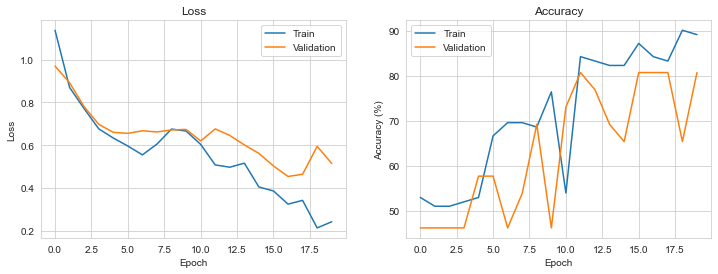

In [11]:
# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Loss
ax1.plot(train_losses, label='Train')
ax1.plot(val_losses, label='Validation')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Accuracy
ax2.plot(train_accuracies, label='Train')
ax2.plot(val_accuracies, label='Validation')
ax2.set_title('Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()

plt.show()

/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


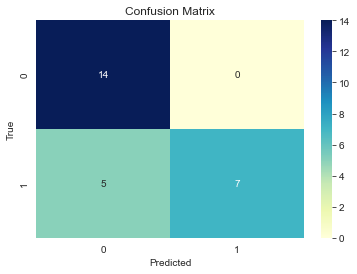

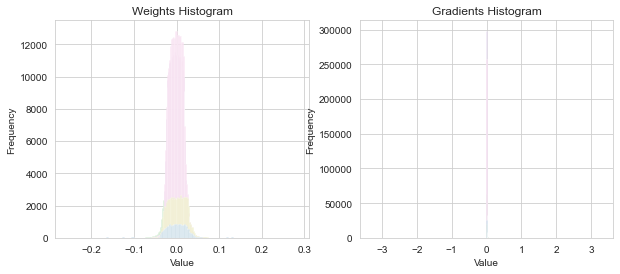

In [12]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, labels, ax=None, title=None):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    if ax is None:
        _, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", ax=ax, xticklabels=labels, yticklabels=labels)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    if title:
        ax.set_title(title)

def get_weights_gradients(model):
    weights = []
    gradients = []
    for name, param in model.named_parameters():
        if param.requires_grad:
            weights.append(param.data.cpu().numpy())
            gradients.append(param.grad.data.cpu().numpy())
    return weights, gradients

def plot_histograms(weights, gradients, figsize=(10, 4)):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

    for w in weights:
        ax1.hist(w.flatten(), bins=100, alpha=0.5)
    ax1.set_title("Weights Histogram")
    ax1.set_xlabel("Value")
    ax1.set_ylabel("Frequency")

    for g in gradients:
        ax2.hist(g.flatten(), bins=100, alpha=0.5)
    ax2.set_title("Gradients Histogram")
    ax2.set_xlabel("Value")
    ax2.set_ylabel("Frequency")

    plt.show()

# Get true labels and predictions on the validation set
y_true = []
y_pred = []
model.eval()
with torch.no_grad():
    for inputs, targets in val_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(targets.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred, labels=[0, 1], title="Confusion Matrix")

# Extract weights and gradients and plot histograms
weights, gradients = get_weights_gradients(model)
plot_histograms(weights, gradients)


In [13]:

# Save the trained model
torch.save(model.state_dict(), "CNNModel_speech_music_discrimination.pth")
print("Model saved.")




Model saved.


In [14]:
# Show model summary
try:
    from torchsummary import summary
    print("\nModel summary:")

    original_device = device
    if device == 'mps': # because MPS is not supported by torchsummary
        device = 'cpu'
    model.to(device)

    summary(model, input_size=(1, 40, 431), device=device)

    if original_device == 'mps': # Restore original device
        device = original_device
        model.to(device)

except ImportError:
    print("\nPlease install torchsummary to display the model summary. Use `pip install torchsummary`.")


Model summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 40, 20, 216]           1,040
              ReLU-2          [-1, 40, 20, 216]               0
            Conv2d-3          [-1, 80, 10, 108]          80,080
              ReLU-4          [-1, 80, 10, 108]               0
            Conv2d-5           [-1, 160, 5, 54]         320,160
              ReLU-6           [-1, 160, 5, 54]               0
   ConvTranspose2d-7          [-1, 80, 10, 108]         320,080
              ReLU-8          [-1, 80, 10, 108]               0
   ConvTranspose2d-9          [-1, 40, 20, 216]          80,040
             ReLU-10          [-1, 40, 20, 216]               0
  ConvTranspose2d-11          [-1, 40, 40, 432]          40,040
             ReLU-12          [-1, 40, 40, 432]               0
AdaptiveAvgPool2d-13             [-1, 40, 1, 1]               0
           Linear-14   